In [1]:
""" This script generates a model for the expected number of variants, given the sequence mutability. It first combines annotations for possible variants, observed variants, VEP annotations and trinucleotide contexts. The proportion of synonymous variants observed in each trinucleotide context is then calculated, and linear models built to describe the relationship between mutability and proportion observed.""";

In [2]:
# Install necessary modules
! conda install statsmodels -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    ca-certificates-2023.01.10 |       h06a4308_0         120 KB
    certifi-2021.5.30          |   py36h06a4308_0         139 KB
    conda-4.10.3               |   py36h06a4308_0         2.9 MB
    intel-openmp-2022.0.1      |    h06a4308_3633         4.2 MB
    libgfortran-ng-7.5.0       |      ha8ba4b0_17          22 KB
    libgfortran4-7.5.0         |      ha8ba4b0_17         995 KB
    mkl-2020.2                 |              256       138.3 MB
    mkl-service

In [3]:
%%bash

# Download data from UKB RAP

dx download \
    -o ../data/ \
    data/cds_trinucleotide_contexts.tsv \
    data/grch38_cpg_methylation.tsv \
    data/gnomad_nc_mutation_rates.tsv \
    data/vep_cds_all_possible_snvs.vcf \
    outputs/gnomad_pass_variants/all_pass_snvs.txt

In [4]:
# Import modules
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [5]:
# Define VCF headers and datatypes.
_header = ["chr", "pos", "id", "ref", "alt", "qual", "filter", "info"]

datatypes = defaultdict(lambda: "str")
datatypes.update({"pos": np.int32, "ac": np.int32, "an": np.int32})

In [6]:
# Retreive observed variants
obs = pd.read_csv(
    "../data/all_pass_snvs.txt",
    sep="\t",
    header=None,
    names=_header + ["ac", "an"],
    usecols=["chr", "pos", "ref", "alt", "ac", "an"],
    dtype=datatypes,
).assign(obs=1)

In [7]:
# Retreive all possible SNVs
pos = pd.read_csv(
    "../data/vep_cds_all_possible_snvs.vcf",
    sep="\t",
    comment="#",
    header=None,
    names=_header,
    dtype=datatypes,
    usecols=["chr", "pos", "ref", "alt"],
)

In [8]:
# Retreive VEP annotations of all possible SNVs
vep = pd.read_csv(
    "../data/vep_cds_all_possible_snvs.vcf",
    sep="\t",
    comment="#",
    header=None,
    names=_header,
    dtype=datatypes,
    usecols=["chr", "pos", "ref", "alt", "info"],
)

In [9]:
# Limit to synonymous variants only
syn = pd.Series(["synonymous" in x for x in vep["info"]])
vep = vep.drop("info", axis=1).loc[syn].assign(csq="synonymous")

In [10]:
# Trinucleotide contexts
tri = pd.read_csv(
    "../data/cds_trinucleotide_contexts.tsv", sep="\t", dtype=datatypes
)

In [11]:
# ENCODE methylation data
meth = (pd.read_csv("../data/grch38_cpg_methylation.tsv", 
                    sep="\t",
                    header=0,
                    names=["ix","chr","pos","alleles","lvl"],
                    usecols=["chr","pos","lvl"],
                   )
       )

In [12]:
# Mutation rates
mu = pd.read_csv(
    "../data/gnomad_nc_mutation_rates.tsv",
    sep="\t",
    names=["tri", "ref", "alt", "lvl", "variant_type", "mu", "pos", "obs", "po", "ppo",],
    header=0,
    usecols=["tri", "ref", "alt", "lvl", "mu", "variant_type"],
)

# Mutation rates are only available for 32 codons. We need to reverse-complement for the remainder.
complement = {"A": "T", "C": "G", "G": "C", "T": "A"}
# Replace ref and alt alleles
_mu = mu.copy().replace(complement)
# Reverse-complement trinucleotide contexts
_mu["tri"] = pd.Series(["".join([complement[y] for y in x])[::-1] for x in mu.tri])
mu = pd.concat([mu, _mu])

In [13]:
# Merge variant annotations
df = pos.merge(obs, how="left").fillna(0)
df = df.merge(vep, how="left").dropna()
df = df.merge(tri, how="left")

In [14]:
df_spare = df.copy()

In [15]:
# Merge methylation and mutability annotations

## Find the number of CpG sites not represented in the ENCODE data
variant_types = mu[["tri", "ref", "alt", "variant_type"]].drop_duplicates()
df = df.merge(variant_types, how="left")
df = df.merge(meth, how="left")

## All non-CpG sites have lvl 0
df.loc[df["variant_type"] != "CpG", "lvl"] = 0
df.lvl = df.lvl.astype(int)

## Merge with mutability data
df = df.merge(mu, how="left")

In [16]:
# Drop contexts in which a synonymous variant is generally not possible.
## (Synonymous variants in these contexts may occur at splice junctions)
m1 = (df.tri == "AGT") & ((df.alt == "C") | (df.alt == "T"))
m2 = (df.tri == "AAT") & ((df.alt == "C") | (df.alt == "T"))
m3 = (df.tri == "ACT") & ((df.alt == "G") | (df.alt == "A"))
m4 = (df.tri == "ATT") & ((df.alt == "G") | (df.alt == "A"))

df = df[~(m1 | m2 | m3 | m4)]

In [17]:
df_common = df.copy()

In [18]:
df = df[(df["an"] == 0) | (df["ac"] / df["an"] < 0.001)]

# Plots

In [60]:
sns.set_context("talk")

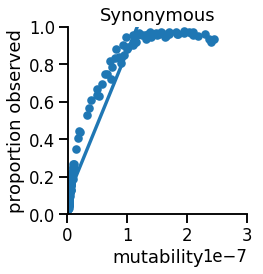

In [91]:
g = sns.lmplot(
    data=df,
    x="mu",
    y="obs",
    ci=None,
    x_estimator=np.mean,
    height=4,
)
g.set(
    title="Synonymous", 
    xlabel="mutability", 
    ylabel="proportion observed", 
    #xscale="log",
    ylim=(0,1),
    xlim=(8*10**-10, 3*10**-7)
)

## Square root mutability

In [20]:
df["sqrt_mu"] = np.sqrt(df["mu"])

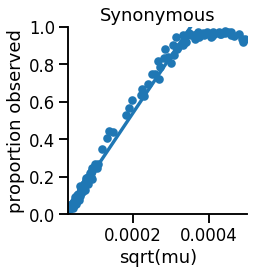

In [94]:
g = sns.lmplot(
    data=df,
    x="sqrt_mu",
    y="obs",
    ci=None,
    x_estimator=np.mean,
    height=4,
)
g.set(title="Synonymous", 
      xlabel="sqrt(mu)", 
      ylabel="proportion observed", 
      #xscale="log",
      xlim=(2.9*10**-5,5*10**-4),
      ylim=(0,1),
     )

## Exponential mutability

In [118]:
fit_mu = np.polyfit(stats["mu"], np.log(stats["obs"]), 1)

In [127]:
df["log_obs"] = np.log(df["obs"])

/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


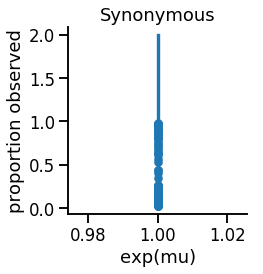

In [125]:
g = sns.lmplot(
    data=df,
    x="exp_mu",
    y="obs",
    ci=None,
    x_estimator=np.mean,
    height=4,
)
g.set(title="Synonymous", 
      xlabel="exp(mu)", 
      ylabel="proportion observed", 
      #xscale="log",
      #xlim=(-21, -15),
      #ylim=(0,1),
     )

# Statistics

In [21]:
stats = (
    df.groupby(["tri", "ref", "alt", "lvl"])
    .agg({"mu": "mean", "sqrt_mu": "mean", "obs": "mean", "pos": "count"})
    .reset_index()
)
stats.to_csv("../outputs/mutational_model_stats.tsv", sep="\t", index=False)

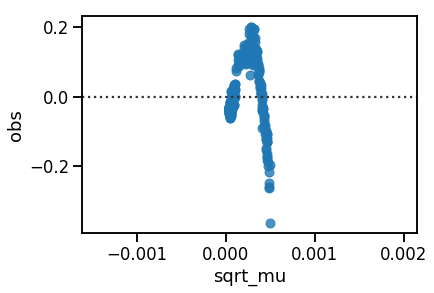

In [66]:
f = sns.residplot(data=stats, x="sqrt_mu", y="obs")

In [67]:
# OLS on mu
model = smf.ols("obs ~ mu", data=stats).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    obs   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1541.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):          1.19e-120
Time:                        17:50:04   Log-Likelihood:                 129.85
No. Observations:                 304   AIC:                            -255.7
Df Residuals:                     302   BIC:                            -248.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1542      0.011     13.525      0.0

In [68]:
# OLS on sqrt(mu)
model = smf.ols("obs ~ sqrt_mu", data=stats).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    obs   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     5899.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):          3.11e-200
Time:                        17:50:04   Log-Likelihood:                 314.24
No. Observations:                 304   AIC:                            -624.5
Df Residuals:                     302   BIC:                            -617.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0101      0.008     -1.342      0.1

In [69]:
# Weighted linear model
model = smf.wls("obs ~ sqrt_mu", data=stats, weights=stats["pos"]).fit()
print(model.summary())

                            WLS Regression Results                            
Dep. Variable:                    obs   R-squared:                       0.979
Model:                            WLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.415e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):          9.80e-256
Time:                        17:50:04   Log-Likelihood:                 495.55
No. Observations:                 304   AIC:                            -987.1
Df Residuals:                     302   BIC:                            -979.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0640      0.002    -30.441      0.0